In [1]:
import jax
import jax_galsim as xgalsim
import galsim
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
jax.devices()

2024-08-09 10:39:37.459961: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-08-09 10:39:58.563105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[cuda(id=0)]

In [106]:
PIXEL_SCALE = 0.2
PSF_HLR = 0.7
FLUX = 1
HLR = 0.9
G1 = 0.05 
G2 = 0.0
X = 0
Y = 0


In [107]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

In [108]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_imshow_with_colorbar(x, ax, fig):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    im = ax.imshow(x)

    fig.colorbar(im, cax=cax, orientation='vertical')

# Real space timing

In [109]:
def _draw_gal(slen=53):
    gal = galsim.Gaussian(flux=FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    gal = gal.shift(dx=X, dy=Y)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=slen,ny=slen,scale=PIXEL_SCALE,
                                 )
    return image.array

GSPARAMS = xgalsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

def draw_gal(slen=53):
    gal = xgalsim.Gaussian(flux=FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    gal = gal.shift(dx=X, dy=Y)
    psf = xgalsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=slen,ny=slen,scale=PIXEL_SCALE,
                                 )
    return image.array

In [110]:
# real space jax galsim (cpu)
cpu_draw_gal = jax.jit(draw_gal, backend='cpu')
print('compilation time jax-galsim real space (CPU)')
%time cpu_draw_gal().block_until_ready() 

print()
print('runtime jax-galsim real space (CPU)')
%timeit cpu_draw_gal().block_until_ready() # `.block_until_ready()` makes it so accelerator actually performs computation

compilation time jax-galsim real space (CPU)
CPU times: user 389 ms, sys: 82.6 ms, total: 471 ms
Wall time: 732 ms

runtime jax-galsim real space (CPU)
12 ms ± 76.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
# real space jax galsim (gpu)
gpu_draw_gal = jax.jit(draw_gal, backend='gpu')
print('compilation time jax-galsim real space (GPU)')
%time gpu_draw_gal().block_until_ready()

print()
print('runtime jax-galsim real space (GPU)')
%timeit gpu_draw_gal().block_until_ready()

compilation time jax-galsim real space (GPU)
CPU times: user 238 ms, sys: 37.9 ms, total: 276 ms
Wall time: 452 ms

runtime jax-galsim real space (GPU)
226 μs ± 1.55 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [112]:
# galsim real space (cpu)
print('runtime GalSim real space')
%timeit _draw_gal()

runtime GalSim real space
443 μs ± 13.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


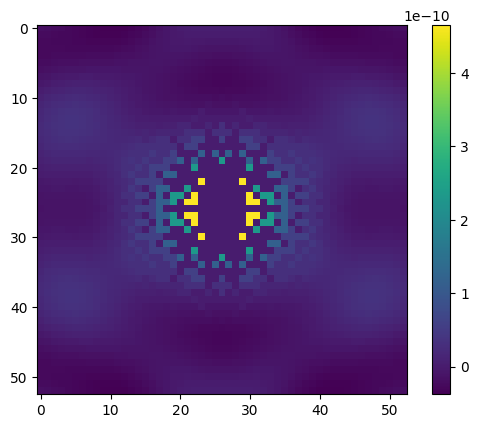

In [113]:
# sanity check
plt.imshow(gpu_draw_gal() - _draw_gal())
plt.colorbar()

# Fourier timing

In [120]:
def _draw_gal_fourier_interpolated(slen=53):
    """We use an interpolated image and then compute the fourier transform.
    
    This mimics what we would get when we applied the method to real data. It also ensures 
    we get the effect of the pixel convolution and WCS (pixel scale). Finally, this is the procedure
    that `ngmix` follows.

    """
    gal = galsim.Gaussian(flux=FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    gal = gal.shift(dx=X, dy=Y)

    # psf and convolution
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    # print('stepk gal:', gal.stepk)
    # print('stepk psf:', psf.stepk)
    gal_conv = galsim.Convolve([gal, psf])
    img = gal_conv.drawImage(nx=slen,ny=slen,scale=PIXEL_SCALE)

    # interpolation and drawkimage
    interp_img = galsim.InterpolatedImage(img, x_interpolant='lanczos15', pad_factor=4) # pad_factor is default
    ft_img = interp_img.drawKImage(nx=slen,ny=slen)
    # print('stepk interp_img:', interp_img.stepk)
    # print('scale fourier img:', ft_img.scale)
    return ft_img

KIMAGE = _draw_gal_fourier_interpolated() # to demonstrate how procedure will work in the end

def _draw_ft_psf(slen=53):
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    psf_img = psf.drawImage(nx=slen,ny=slen,scale=PIXEL_SCALE)
    psf_interp_img = galsim.InterpolatedImage(psf_img, x_interpolant='lanczos15', pad_factor=4) 
    
    # want same fourier scale, but without overwriting original `KIMAGE`
    bounds = galsim.BoundsI(xmin=KIMAGE.bounds.xmin, xmax=KIMAGE.bounds.xmax, ymin=KIMAGE.bounds.ymin, ymax=KIMAGE.bounds.ymax)
    _kimg = galsim.ImageCD(scale = KIMAGE.scale, bounds=bounds)
    
    psf_kimg = psf_interp_img.drawKImage(_kimg)
    return psf_kimg.array

def _draw_fourier_kimage(ft_psf_arr): # galsim
    gal = galsim.Gaussian(flux=FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    gal = gal.shift(dx=X, dy=Y)
    
    # want same fourier scale, but without overwriting original `KIMAGE`
    bounds = galsim.BoundsI(xmin=KIMAGE.bounds.xmin, xmax=KIMAGE.bounds.xmax, ymin=KIMAGE.bounds.ymin, ymax=KIMAGE.bounds.ymax)
    _kimg = galsim.ImageCD(scale = KIMAGE.scale, bounds=bounds)
    
    kimg = gal.drawKImage(_kimg)
    return kimg.array * ft_psf_arr

def _draw_fourier_kimage_jax(ft_psf_arr): #jax-galsim
    gal = xgalsim.Gaussian(flux=FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    gal = gal.shift(dx=X, dy=Y)

    # need to convert to xgalsim object 
    bounds = xgalsim.BoundsI(xmin=KIMAGE.bounds.xmin, xmax=KIMAGE.bounds.xmax, ymin=KIMAGE.bounds.ymin, ymax=KIMAGE.bounds.ymax)
    _kimg = xgalsim.ImageCD(scale = KIMAGE.scale, bounds=bounds)

    kimg = gal._drawKImage(_kimg)
    return kimg.array * ft_psf_arr

In [115]:
# get fourier psf (in jax, cpu and gpu)
# avoid overhead when transferring device to accelerator
ft_psf_arr_cpu = _draw_ft_psf()
ft_psf_arr_cpu_jax = jax.device_put(ft_psf_arr_cpu, device=jax.devices('cpu')[0])
ft_psf_arr_gpu_jax = jax.device_put(ft_psf_arr_cpu, device=jax.devices('gpu')[0])

In [116]:
type(ft_psf_arr_cpu), ft_psf_arr_cpu_jax.devices(), ft_psf_arr_gpu_jax.devices()

(numpy.ndarray, {CpuDevice(id=0)}, {cuda(id=0)})

In [117]:
# fourier space jax galsim (cpu)
draw_fourier_kimage_jax_cpu = jax.jit(_draw_fourier_kimage_jax, backend='cpu')

print('compilation time Fourier JAX-GalSim (CPU)')
%time draw_fourier_kimage_jax_cpu(ft_psf_arr_cpu_jax).block_until_ready()

print()
print('runtime Fourier JAX-GalSim (CPU)')
%timeit draw_fourier_kimage_jax_cpu(ft_psf_arr_cpu_jax).block_until_ready()


compilation time Fourier JAX-GalSim (CPU)
CPU times: user 82.1 ms, sys: 444 μs, total: 82.6 ms
Wall time: 79.4 ms

runtime Fourier JAX-GalSim (CPU)
64.7 μs ± 1.76 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [118]:
# fourier space jax galsim (gpu)
draw_fourier_kimage_jax_gpu = jax.jit(_draw_fourier_kimage_jax, backend='gpu')

print('compilation time Fourier JAX-GalSim (GPU)')
%time draw_fourier_kimage_jax_gpu(ft_psf_arr_gpu_jax).block_until_ready()

print()
print('runtime Fourier JAX-GalSim (GPU)')
%timeit draw_fourier_kimage_jax_gpu(ft_psf_arr_gpu_jax).block_until_ready()


compilation time Fourier JAX-GalSim (GPU)
CPU times: user 93.2 ms, sys: 0 ns, total: 93.2 ms
Wall time: 117 ms

runtime Fourier JAX-GalSim (GPU)
75.4 μs ± 1.42 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [121]:
# fourier space galsim
print('runtime GalSim Fourier')
%timeit _draw_fourier_kimage(ft_psf_arr_cpu)


runtime GalSim Fourier
75.3 μs ± 3.37 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


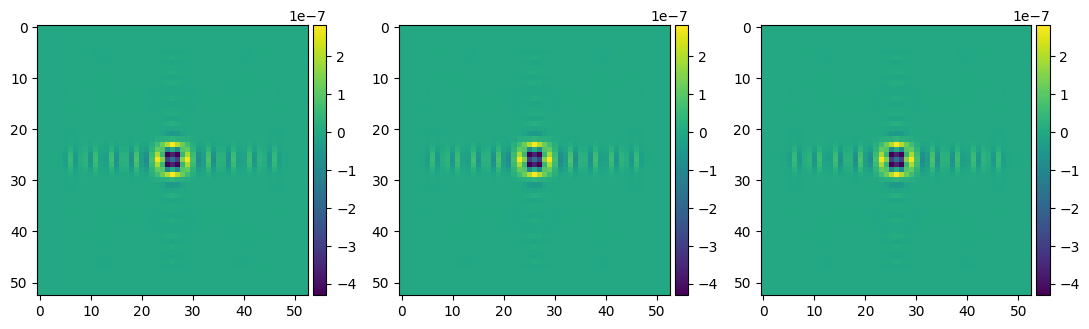

In [122]:
# all functions have low residuals
target_im = _draw_gal_fourier_interpolated().array
im1 = _draw_fourier_kimage(ft_psf_arr_cpu)
im2 = draw_fourier_kimage_jax_cpu(ft_psf_arr_cpu_jax)
im3 = draw_fourier_kimage_jax_gpu(ft_psf_arr_gpu_jax)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))
                                    
plot_imshow_with_colorbar(target_im.real - im1.real, ax1, fig)
plot_imshow_with_colorbar(target_im.real - im2.real, ax2, fig)
plot_imshow_with_colorbar(target_im.real - im3.real, ax3, fig)
plt.tight_layout()

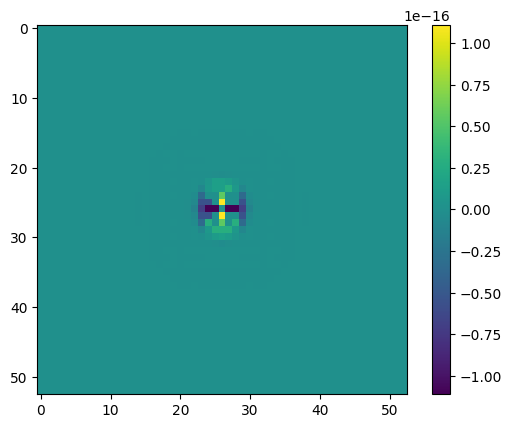

In [123]:
# individual differences very small
im1 = _draw_fourier_kimage(ft_psf_arr_cpu)
im2 = draw_fourier_kimage_jax_gpu(ft_psf_arr_gpu_jax)
plt.imshow(im1.real - im2.real)
plt.colorbar()

# Fourier HMC

In [41]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import chainconsumer as cc
import pandas as pd

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [243]:
PIXEL_SCALE = 0.2
PSF_HLR = 0.7
FLUX = 10**(5.0)
HLR = 0.9
G1 = 0.02
G2 = 0.0
X = 0
Y = 0
BACKGROUND = 1e4

TRUE_PARAMS = {'f': FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x':X, 'y': Y}

In [244]:
def add_noise(x: np.ndarray, bg: float, n=1, noise_factor=1):
    """Produce `n` independent Gaussian noise realizations of a given image `x`.

    NOTE: This function assumes image is background-subtracted and dominated.
    """
    x = x.reshape(1, *x.shape)
    x = x.repeat(n, axis=0)
    noise = np.random.randn(*x.shape) * np.sqrt(bg) * noise_factor
    return x + noise, noise

def _draw_noisy_fourier_interpolated_gal(slen=53):
    """We use an interpolated image and then compute the fourier transform.
    
    This mimics what we would get when we applied the method to real data. It also ensures 
    we get the effect of the pixel convolution and WCS (pixel scale). Finally, this is the procedure
    that `ngmix` follows.

    """
    gal = galsim.Gaussian(flux=FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    gal = gal.shift(dx=X, dy=Y)

    # psf and convolution
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    img = gal_conv.drawImage(nx=slen,ny=slen,scale=PIXEL_SCALE)
    
    # add noise
    img = img + np.random.randn(*img.array.shape) * np.sqrt(BACKGROUND)

    # interpolation and drawkimage
    interp_img = galsim.InterpolatedImage(img, x_interpolant='lanczos15', pad_factor=4)
    ft_img = interp_img.drawKImage(nx=slen,ny=slen)
    return ft_img, img

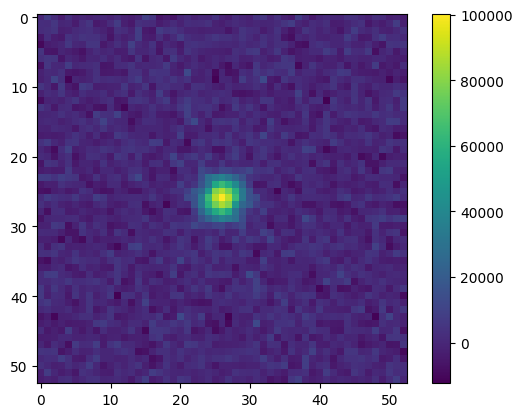

In [245]:
TARGET, real_img = _draw_noisy_fourier_interpolated_gal()
plt.imshow(TARGET.array.real)
plt.colorbar()

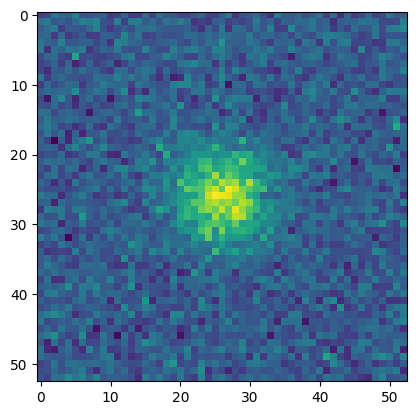

In [246]:
plt.imshow(real_img.array)

In [247]:
def _draw_fourier_psf(slen=53):
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    psf_img = psf.drawImage(nx=slen,ny=slen,scale=PIXEL_SCALE)
    psf_interp_img = galsim.InterpolatedImage(psf_img, x_interpolant='lanczos15', pad_factor=4) 
    
    # want same fourier scale, but without overwriting original `KIMAGE`
    bounds = galsim.BoundsI(xmin=TARGET.bounds.xmin, xmax=TARGET.bounds.xmax, ymin=TARGET.bounds.ymin, ymax=TARGET.bounds.ymax)
    _kimg = galsim.ImageCD(scale = TARGET.scale, bounds=bounds)
    
    psf_kimg = psf_interp_img.drawKImage(_kimg)
    return psf_kimg.array

In [248]:
FT_PSF_JAX = jax.device_put(_draw_fourier_psf(), device=jax.devices('gpu')[0]) # move to gpu

In [249]:
@jax.jit
def _draw_fourier_kimage_jax(f, hlr, g1, g2, x, y):
    gal = xgalsim.Gaussian(flux=f, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    gal = gal.shift(dx=x, dy=y)

    # need to convert to xgalsim object 
    bounds = xgalsim.BoundsI(xmin=TARGET.bounds.xmin, xmax=TARGET.bounds.xmax, ymin=TARGET.bounds.ymin, ymax=TARGET.bounds.ymax)
    _kimg = xgalsim.ImageCD(scale = TARGET.scale, bounds=bounds)

    kimg = gal._drawKImage(_kimg)
    return kimg.array * FT_PSF_JAX

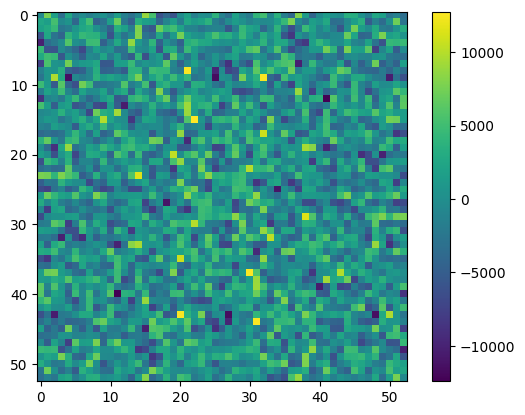

In [250]:
res = TARGET.array - _draw_fourier_kimage_jax(**TRUE_PARAMS)
plt.imshow(res.real)
plt.colorbar()

In [251]:
TARGET_JAX = jax.device_put(TARGET.array, device=jax.devices('gpu')[0]) # move to target image to gpu

In [252]:
# compute error to be used when evaluating likelihood
wt = TARGET_JAX.real*0 + 1.0/BACKGROUND
useweight = wt.max()
weight = TARGET_JAX.real*0 + 0.5*useweight

# parseval's theorem
weight *= (1.0/weight.size)

# get ierr
# IERR = jnp.where(weight > 0, jnp.
IERR = weight.copy() * 0
w = jnp.where(weight > 0)
if w[0].size > 0: 
    IERR = IERR.at[w].set(jnp.sqrt(weight[w]))

# IERR[weight > 0] = jnp.sqrt(weight[weight > 0])
# w = jnp.where(weight > 0)
# if w[0].size > 0:
    # IERR[w] = jnp.sqrt(weight[w])


In [253]:
# TODO: Check if IERR having imaginary part = 0 is correct? 
IERR_JAX = jax.device_put(IERR, jax.devices('gpu')[0])

In [257]:
def prob_model(data):
    lf = numpyro.sample('lf', dist.Uniform(4,6))
    hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))
    x = numpyro.sample('x', dist.Uniform(-0.5, 0.5))
    y = numpyro.sample('y', dist.Uniform(-0.5, 0.5))
    
    ## use magnitude and angle as priors 
    ## ngmix priors might be helpful (but challenging)
    e1 = numpyro.sample('e1', dist.Uniform(-0.4, 0.4)) # TODO: change to GAussian priors
    e2 = numpyro.sample('e2', dist.Uniform(-0.4, 0.4))
    # e1 = numpyro.sample('e1', dist.Normal(0.0, 0.1))
    # e2 = numpyro.sample('e2', dist.Normal(0.0, 0.1))
    model = _draw_fourier_kimage_jax(10**lf, hlr, g1=e1, g2=e2, x=x, y=y)
    flat_model = jnp.concatenate([model.real.flatten(), model.imag.flatten()])
    flat_data = jnp.concatenate([data.real.flatten(), data.imag.flatten()])
    flat_err = jnp.concatenate([IERR_JAX.flatten(), IERR_JAX.flatten()])
    # numpyro.sample('obs', dist.Normal(flat_model, 2928.9312), obs=flat_data)
    # numpyro.sample('obs', dist.Normal(flat_model, jnp.sqrt(BACKGROUND)), obs=flat_data)
    # numpyro.sample('obs', dist.Normal(flat_model, 21.), obs=flat_data)
    numpyro.sample('obs', dist.Normal(flat_model, 1/flat_err), obs=flat_data)
    # numpyro.sample('obs', dist.Normal(flat_model, 3219.44746872), obs=flat_data)


In [258]:
nuts_kernel = NUTS(prob_model, max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, data=TARGET_JAX)

sample: 100%|██████████| 1500/1500 [00:15<00:00, 99.92it/s, 7 steps of size 4.85e-01. acc. prob=0.94]  


In [256]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        e1     -0.00      0.03     -0.00     -0.06      0.04   1629.15      1.00
        e2      0.04      0.03      0.04     -0.01      0.10   1903.81      1.00
       hlr      0.86      0.03      0.86      0.81      0.91    761.02      1.00
        lf      4.99      0.01      4.99      4.97      5.02    881.23      1.00
         x      0.03      0.03      0.03     -0.02      0.07   1367.03      1.00
         y      0.02      0.03      0.02     -0.02      0.07   1558.71      1.00

Number of divergences: 0


In [262]:
c.analysis.get_parameter_summary(Chain(samples=df, name=f"Chain"), column=['e1', 'e2'])

ValueError: weights should have the same shape as a.

Parameter lf in chain Chain is not constrained


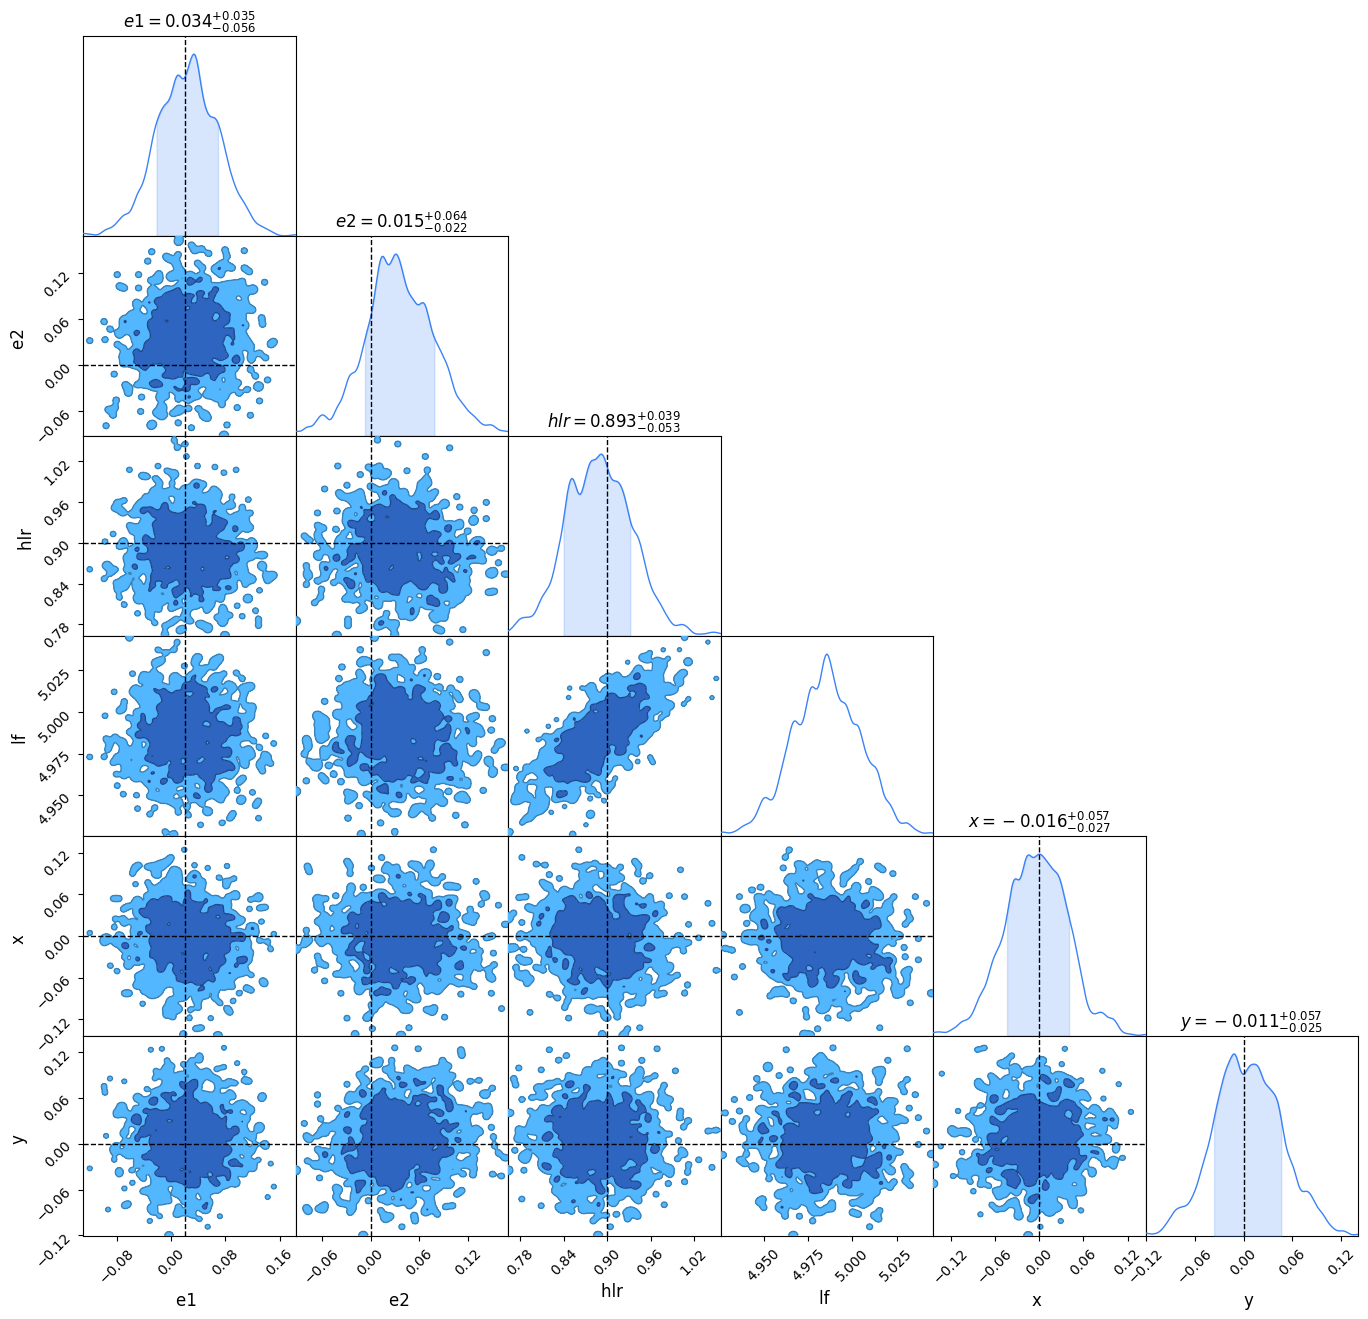

In [236]:
# now plot multiple contours
import pandas as pd
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth, make_sample

c = ChainConsumer()
samples = mcmc.get_samples()
df = pd.DataFrame.from_dict(samples)

c.add_chain(Chain(samples=df, name=f"Chain"))

truth = {**TRUE_PARAMS}
for k in ['g1', 'g2']:
    if k == 'g1':
        truth['e1'] = truth['g1']
        del truth['g1']
    elif k == 'g2':
        truth['e2'] = truth['g2']
        del truth['g2']

c.add_truth(Truth(location=truth))
fig = c.plotter.plot()
